In [1]:
#import sys
#!{sys.executable} -m pip install xgboost
#!{sys.executable} -m pip install fancyimpute

In [3]:
import numpy as np
import xgboost as xgb
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold
#from fancyimpute import KNN

from sklearn.preprocessing import PolynomialFeatures
# Import Linear Regression and a regularized regression function
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
# Finally, import function to make a machine learning pipeline
from sklearn.pipeline import make_pipeline

## Load Data

In [6]:
X = pd.read_csv('data/X_train.csv')
Y = pd.read_csv('data/Y_train.csv')
X_test = pd.read_csv('data/X_test.csv')

print("Training Data:{}".format(X.shape))
print("Test Data:{}".format(X_test.shape))

Y.head(2)


Training Data:(1212, 888)
Test Data:(776, 888)


,id,y
0,0.0,75.0
1,1.0,76.0


In [7]:
Y['y'].describe()

count    1212.000000
mean       69.763201
std         9.941656
min        42.000000
25%        64.000000
50%        70.000000
75%        76.000000
max        96.000000
Name: y, dtype: float64

In [8]:
X.describe()

,id,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x877,x878,x879,x880,x881,x882,x883,x884,x885,x886
count,1212.000000,1122.000000,1.140000e+03,1.132000e+03,1123.000000,1133.000000,1126.000000,1141.000000,1122.000000,1122.000000,...,1.127000e+03,1.127000e+03,1.132000e+03,1127.000000,1.125000e+03,1127.000000,1148.000000,1126.000000,1123.000000,1111.000000
mean,605.500000,7300.504957,1.003125e+06,1.051614e+06,1049.844772,105.047681,203511.156265,1050.735880,341958.172245,104916.372111,...,3.825322e+11,1.003145e+06,-5.025956e+05,1001.891614,9.995905e+05,3732.365716,100.659348,1617.956555,10505.966555,65052.578569
std,350.018571,1379.891266,1.001817e+05,2.818085e+04,28.475255,2.823009,29841.633207,28.623527,58820.438523,2755.013692,...,4.347959e+11,9.594847e+04,8.608874e+04,100.410174,9.680491e+04,725.532171,9.336065,401.791865,290.648021,0.029221
min,0.000000,1030.502715,6.716345e+05,1.000037e+06,1000.062471,100.033879,63202.600024,1000.134779,92365.078214,100016.602565,...,-5.083882e+11,7.186635e+05,-1.110029e+06,643.042857,6.895354e+05,451.131089,65.692019,458.289896,10001.346875,65052.528022
25%,302.750000,6496.988432,9.409699e+05,1.028118e+06,1025.913567,102.724769,186609.583069,1026.464126,309182.739540,102687.100342,...,1.578603e+11,9.385117e+05,-5.475966e+05,933.591537,9.348641e+05,3297.203036,94.515998,1360.553119,10249.981685,65052.553207
50%,605.500000,7381.752216,1.003238e+06,1.052406e+06,1050.174694,105.023063,201709.971057,1051.399190,337308.178918,104861.600927,...,2.758197e+11,1.001974e+06,-4.965350e+05,1001.295903,9.989761e+05,3768.931107,100.672131,1604.528424,10505.538263,65052.579678
75%,908.250000,8153.767104,1.070372e+06,1.075329e+06,1074.864998,107.391464,220981.402036,1075.166305,371797.754187,107160.482832,...,4.867297e+11,1.063238e+06,-4.560057e+05,1069.927335,1.064618e+06,4179.602230,106.809319,1861.784028,10763.810688,65052.603107
max,1211.000000,13055.814408,1.316548e+06,1.099990e+06,1099.845375,110.048177,370398.522988,1099.997865,784817.830992,109991.914244,...,7.405700e+12,1.308895e+06,-1.400403e+05,1323.073354,1.276136e+06,6781.164024,126.678078,3745.022165,10999.908941,65052.627907


## Preprocessing

### Replace missing values: 

In [9]:
print("Missing entries in training data across all features: ",X.isnull().sum().sum())

print("Missing entries in test data across all features: ",X_test.isnull().sum().sum())

Missing entries in training data across all features:  77121
Missing entries in test data across all features:  46382


In [24]:
X = X.interpolate(method = 'nearest').ffill().bfill()
X_test = X_test.interpolate(method = 'nearest').ffill().bfill()

X.to_csv('X_imputed.csv')
X_test.to_csv('X_test_imputed.csv')


### Data normalization

In [11]:
# Get column names first
names = X.columns
#X_normalized = preprocessing.normalize(X_normalized)
#X_test_normalized = preprocessing.normalize(X_test_normalized)
# Create the Scaler object
scaler = preprocessing.StandardScaler()
scaler.fit(X)
# Fit your data on the scaler object
X_normalized = scaler.transform(X)
X_test_normalized = scaler.transform(X_test)

In [12]:
print(np.max(np.var(X_normalized)))

0.9954954954954955


## Training / Validation Spilt

In [13]:
# Using normalized X here!
X_train, X_val, Y_train, Y_val =train_test_split(X_normalized, Y, test_size=0.2, random_state=42)
print("X_train: {}".format(X_train.shape))
print("X_val: {}".format(X_val.shape))

X_train: (969, 888)
X_val: (243, 888)


In [14]:
print(np.max(np.var(X_train, axis=0)))
print(np.var(X_train, axis=0).shape)

1.1633880909767842
(888,)


## Feature Selection

### Remove features with low variance

In [15]:
print("initial shape of X_train:{}".format(X_train.shape))
print("initial shape of X_val:{}".format(X_val.shape))
print("initial shape of X_test:{}".format(X_test_normalized.shape))

selector = VarianceThreshold()
selector.fit(X_train)

X_train = selector.transform(X_train)
indices_retained = selector.get_support(indices=False)
print(indices_retained.shape)
# need to convert X_val to pandas dataframe to use .loc to select features
X_val_df = (pd.DataFrame(data=X_val))
X_val = X_val_df.loc[:,indices_retained]
X_test_normalized_df = pd.DataFrame(data=X_test_normalized)
X_test_normalized = X_test_normalized_df.loc[:,indices_retained]

print("new shape of X_train:{}".format(X_train.shape))
print("new shape of X_val:{}".format(X_val.shape))
print("new shape of X_test:{}".format(X_test_normalized.shape))


initial shape of X_train:(969, 888)
initial shape of X_val:(243, 888)
initial shape of X_test:(776, 888)
(888,)
new shape of X_train:(969, 884)
new shape of X_val:(243, 884)
new shape of X_test:(776, 884)


### Remove features which highly correlate with other features

In [16]:
print("initial shape of X_train:{}".format(X_train.shape))
print("initial shape of X_val:{}".format(X_val.shape))
print("initial shape of X_test:{}".format(X_test_normalized.shape))

# Create correlation matrix
X_train_df = (pd.DataFrame(data=X_train))
corr_matrix = X_train_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
X_train = X_train_df.drop(X_train_df.columns[to_drop], axis=1)
X_val = X_val.drop(X_val.columns[to_drop], axis=1)
X_test_normalized = X_test_normalized.drop(X_test_normalized.columns[to_drop], axis=1)

print("new shape of X_train:{}".format(X_train.shape))
print("new shape of X_val:{}".format(X_val.shape))
print("new shape of X_test:{}".format(X_test_normalized.shape))



initial shape of X_train:(969, 884)
initial shape of X_val:(243, 884)
initial shape of X_test:(776, 884)
new shape of X_train:(969, 831)
new shape of X_val:(243, 831)
new shape of X_test:(776, 831)


In [17]:
np.average(X_train,axis=0)

array([ 2.48814224e-02, -2.86999391e-02,  1.84213645e-02, -6.01563020e-03,
        2.54950949e-02, -1.85056098e-03, -1.95678583e-02,  2.34277990e-02,
       -1.57632098e-02,  1.77335837e-02, -4.41920151e-03, -9.29518301e-03,
       -3.68781857e-04, -8.40663466e-03, -4.91374601e-03,  2.06509119e-02,
       -1.69466066e-03, -6.61480756e-03, -2.01020209e-03, -2.44808824e-02,
       -1.29400164e-02,  1.78617889e-03,  9.85952519e-03,  2.16590801e-02,
        1.01599750e-02, -5.67979343e-03, -6.74367679e-03, -1.05101477e-02,
       -1.15773867e-02, -8.16859268e-03, -5.57564704e-03, -7.99673438e-03,
       -1.31986970e-02, -9.87491129e-03,  1.80029492e-02, -2.45460090e-02,
        1.28044501e-02, -1.49594766e-02, -1.11349179e-02,  1.00866228e-02,
       -8.57391211e-03, -4.60545173e-03,  1.22202056e-03, -3.78602165e-03,
        1.04620468e-02,  1.97565459e-04, -1.33750293e-03,  3.46565196e-03,
        1.69640043e-02,  4.33448831e-03, -1.09779192e-03, -4.28964299e-03,
       -5.52105759e-03,  

### PCA

In [18]:
print(np.max(np.var(X_train,axis=0)))
print(np.var(X_train,axis=0).shape)

1.1633880909767842
(831,)


831
[ 59.09526774  84.08098203  90.68081866  96.01544406 100.32747452
 104.18302855]


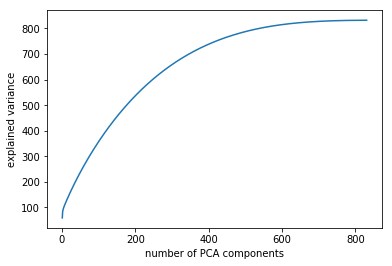

In [19]:
n_columns = X_train.shape[1]
print(n_columns)
pca = PCA(n_components = n_columns)
pca.fit(X_train)
components = np.linspace(1, n_columns, n_columns)
explained_var = np.zeros(n_columns)
explained_var[0] = pca.explained_variance_[0]
for i in range(1,n_columns+1):
    explained_var[i-1] = explained_var[i-2] + pca.explained_variance_[i-1]
  #explained_var[i-1] = pca.explained_variance_ratio_[i-1]
print(explained_var[0:6])
plt.plot(components,explained_var, label="Sum of explained variance")
plt.xlabel('number of PCA components')
plt.ylabel('explained variance')
plt.show()

## Algorithm

### Linear Regression

In [20]:
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)
# Make predictions using the validation set
Y_pred = regr.predict(X_val)

print('R2 score: %.2f' % r2_score(Y_val, Y_pred))

R2 score: -2.13


### XgBoost

In [21]:
dtrain = xgb.DMatrix(X_train)
dtest = xgb.DMatrix(X_test)

In [22]:
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000
# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 8
# Test/train split
# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
# for degree in range(degree_min,degree_max+1):
#     model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
# normalize=True,cv=5))
#     model.fit(X_train,Y_train)
#     Y_pred = np.array(model.predict(X_test))
    
#     print('R2 score: %.2f' % r2_score(Y_test, Y_pred))

    